In [44]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import urllib
import json

tf.__version__

'2.10.0'

In [7]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

('sarcasm.json', <http.client.HTTPMessage at 0x16d47ed00>)

In [28]:
headlines = []
links = []
labels = []

In [29]:
f = open('sarcasm.json')

data = json.load(f)

for item in data:
    headlines.append(item['headline'])
    links.append(item['article_link'])
    labels.append(item['is_sarcastic'])

In [30]:
from sklearn.model_selection import train_test_split

(26709, 26709)

In [31]:
train_headlines, val_headlines, train_labels, val_labels = train_test_split(headlines,
                                                                            labels,
                                                                            test_size=0.1,
                                                                            random_state=42)

In [32]:
train_headlines[:10], train_labels[:10]

(['win a $10,000 mall of america dream shooting spree!',
  'cash-strapped oklahoma to conduct executions by hammering squad',
  'what will the disruption of politics look like?',
  'three qualities a woman should possess to be powerful, from jill abramson (video)',
  "david petraeus: white house is wrong, generals are 'fair game' for criticism",
  'queen bun gives birth to thousands of tiny rolls',
  "behind the black curtain with tom brady: tears and concerns over patriots' dynasty",
  'your four-legged friends are leaving a serious carbon pawprint on the planet',
  'herpetologist names son after famous herpetologist',
  'should banks be allowed to robocall your mobile phone?'],
 [1, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [40]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)
text_vectorizer.adapt(train_headlines)
len(text_vectorizer.get_vocabulary())

26984

### Vocab Size is 26984

In [41]:
sent_lens = [len(headline.split()) for headline in train_headlines]

(array([1.9340e+03, 9.1790e+03, 1.0094e+04, 2.2600e+03, 5.1100e+02,
        4.9000e+01, 4.0000e+00, 5.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 2. ,  5.7,  9.4, 13.1, 16.8, 20.5, 24.2, 27.9, 31.6, 35.3, 39. ]),
 <BarContainer object of 10 artists>)

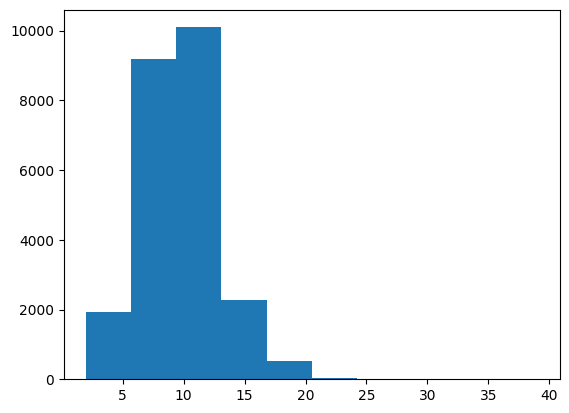

In [45]:
plt.hist(sent_lens)

### Most of the sentences are 21 words long

In [55]:
max_vocab_length = 20000
max_sentence_length = 21

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_sentence_length)
text_vectorizer.adapt(train_headlines)

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_headlines, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_headlines, val_labels))

BATCH_SIZE = 32

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [71]:
tf.random.set_seed(42)

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer="uniform",
                                      input_length=max_sentence_length,
                                      name="embedding_1")

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_Bidirectional")


In [72]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [73]:
model_1_history = model_1.fit(train_dataset,
                              epochs=20,
                              validation_data=val_dataset,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

Epoch 1/20
752/752 [==============================] - 21s 24ms/step - loss: 0.3750 - accuracy: 0.8284 - val_loss: 0.3163 - val_accuracy: 0.8600
Epoch 2/20
752/752 [==============================] - 18s 24ms/step - loss: 0.1613 - accuracy: 0.9375 - val_loss: 0.3725 - val_accuracy: 0.8581
Epoch 3/20
752/752 [==============================] - 17s 23ms/step - loss: 0.0551 - accuracy: 0.9812 - val_loss: 0.5453 - val_accuracy: 0.8401
Epoch 4/20
752/752 [==============================] - 18s 23ms/step - loss: 0.0350 - accuracy: 0.9882 - val_loss: 0.6537 - val_accuracy: 0.8472
Epoch 5/20
752/752 [==============================] - 17s 22ms/step - loss: 0.0262 - accuracy: 0.9910 - val_loss: 0.6799 - val_accuracy: 0.8390
Epoch 6/20
752/752 [==============================] - 17s 22ms/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.6634 - val_accuracy: 0.8409


In [90]:
model_1.evaluate(val_dataset)

84/84 [==============================] - 1s 5ms/step - loss: 0.3163 - accuracy: 0.8600


[0.3163367211818695, 0.8599775433540344]

In [75]:
tf.random.set_seed(42)

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer="uniform",
                                      input_length=max_sentence_length,
                                      name="embedding_1")

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_1_Bidirectional")

In [76]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
model_2_history = model_2.fit(train_dataset,
                              epochs=20,
                              validation_data=val_dataset,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

Epoch 1/20
752/752 [==============================] - 14s 17ms/step - loss: 0.3864 - accuracy: 0.8245 - val_loss: 0.3553 - val_accuracy: 0.8574
Epoch 2/20
752/752 [==============================] - 13s 17ms/step - loss: 0.1799 - accuracy: 0.9322 - val_loss: 0.4509 - val_accuracy: 0.8480
Epoch 3/20
752/752 [==============================] - 13s 17ms/step - loss: 0.0749 - accuracy: 0.9768 - val_loss: 0.5479 - val_accuracy: 0.8431
Epoch 4/20
752/752 [==============================] - 13s 17ms/step - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.6310 - val_accuracy: 0.8443
Epoch 5/20
752/752 [==============================] - 12s 16ms/step - loss: 0.0417 - accuracy: 0.9864 - val_loss: 0.6194 - val_accuracy: 0.8465
Epoch 6/20
752/752 [==============================] - 12s 16ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.7271 - val_accuracy: 0.8379


In [89]:
model_2.evaluate(val_dataset)

84/84 [==============================] - 0s 4ms/step - loss: 0.5435 - accuracy: 0.8443


[0.5435160994529724, 0.8442530632019043]

In [84]:
tf.random.set_seed(42)

embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      embeddings_initializer="uniform",
                                      input_length=max_sentence_length,
                                      name="embedding_1")

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(64, return_sequences=True)(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_1_Bidirectional")

In [85]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [86]:
model_3_history = model_2.fit(train_dataset,
                              epochs=20,
                              validation_data=val_dataset,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)])

Epoch 1/20
752/752 [==============================] - 12s 16ms/step - loss: 0.0817 - accuracy: 0.9720 - val_loss: 0.5435 - val_accuracy: 0.8443
Epoch 2/20
752/752 [==============================] - 12s 16ms/step - loss: 0.0537 - accuracy: 0.9833 - val_loss: 0.5768 - val_accuracy: 0.8341
Epoch 3/20
752/752 [==============================] - 12s 16ms/step - loss: 0.0360 - accuracy: 0.9891 - val_loss: 0.7501 - val_accuracy: 0.8439
Epoch 4/20
752/752 [==============================] - 12s 16ms/step - loss: 0.0293 - accuracy: 0.9907 - val_loss: 0.8184 - val_accuracy: 0.8416
Epoch 5/20
752/752 [==============================] - 13s 17ms/step - loss: 0.0262 - accuracy: 0.9919 - val_loss: 0.8859 - val_accuracy: 0.8461
Epoch 6/20
752/752 [==============================] - 13s 17ms/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.9049 - val_accuracy: 0.8293


In [92]:
model_3.evaluate(val_dataset)

84/84 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5680


[0.6924570202827454, 0.5679520964622498]

In [94]:
import tensorflow_hub as hub

In [95]:
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [101]:
model_4 = tf.keras.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
], name="model_3_USE")

In [102]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [103]:
model_4_history = model_4.fit(train_dataset,
                              epochs=20,
                              validation_data=val_dataset,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,restore_best_weights=True)])

Epoch 1/20
752/752 [==============================] - 3s 3ms/step - loss: 0.4723 - accuracy: 0.7728 - val_loss: 0.4290 - val_accuracy: 0.7948
Epoch 2/20
752/752 [==============================] - 2s 2ms/step - loss: 0.4117 - accuracy: 0.8073 - val_loss: 0.4041 - val_accuracy: 0.8094
Epoch 3/20
752/752 [==============================] - 2s 2ms/step - loss: 0.3831 - accuracy: 0.8244 - val_loss: 0.3886 - val_accuracy: 0.8188
Epoch 4/20
752/752 [==============================] - 2s 2ms/step - loss: 0.3584 - accuracy: 0.8384 - val_loss: 0.3779 - val_accuracy: 0.8233
Epoch 5/20
752/752 [==============================] - 2s 2ms/step - loss: 0.3365 - accuracy: 0.8511 - val_loss: 0.3710 - val_accuracy: 0.8282
Epoch 6/20
752/752 [==============================] - 2s 2ms/step - loss: 0.3166 - accuracy: 0.8628 - val_loss: 0.3667 - val_accuracy: 0.8345
Epoch 7/20
752/752 [==============================] - 2s 2ms/step - loss: 0.2981 - accuracy: 0.8720 - val_loss: 0.3639 - val_accuracy: 0.8349
Epoch 

In [105]:
model_4.evaluate(val_dataset)

84/84 [==============================] - 0s 2ms/step - loss: 0.3629 - accuracy: 0.8416


[0.3629273772239685, 0.8416323661804199]